In [198]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import itertools
import time
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
import tensorflow as tf

In [2]:
sessions = pd.read_csv('sessions.csv', index_col=0)
sessions.rename(columns={'SessionID':'SessionId'}, inplace=True)
sessions.shape

(112256, 6)

**From the documentation**: *TimeStamp – long integer value specifying the UTC date and time of the arrival of a request, coded as the number of 100-nanosecond intervals that have elapsed since 00:00:00 UTC on 1st January, 1 A.D.*

In [3]:
seconds = (datetime(1970,1,1)-datetime(1,1,1)).total_seconds()
ticks = seconds * 10**7
sessions['TimeStamp'] = pd.to_datetime((sessions['TimeStamp']-ticks)*100)
sessions.head()

,SessionId,IpId,TimeStamp,Event,Action,Product
0,0,100095PL,2020-01-13 21:35:36,Leave,NaN,NaN
1,1,100095PL,2020-04-18 16:14:40,Arrive,NaN,NaN
2,1,100095PL,2020-04-18 16:15:26,NaN,add_to_cart,p-9967
3,1,100095PL,2020-04-18 16:33:07,NaN,order,NaN
4,1,100095PL,2020-04-18 16:34:25,Leave,NaN,NaN


In [4]:
train = sessions[sessions['TimeStamp']<=datetime(2020,3,31,23,59,59)]
test = sessions[sessions['TimeStamp']>datetime(2020,3,31,23,59,59)]

In [5]:
items = train['Product'].dropna().unique()
print(items.shape)

(4038,)


In [6]:
users = train['IpId'].unique()
print(users.shape)

(8694,)


In [58]:
withProduct = train[~train['Product'].isnull()].groupby('IpId')['Product'].apply(set)
with3Plus = withProduct[pd.Series(withProduct).apply(len)>2]
with3Plus = with3Plus.index.to_list()
print(len(with3Plus))

1405


In [99]:
mask = train['IpId'].apply(lambda y: y in with3Plus)
activeUsers = train[mask]
userBaskets = activeUsers[~activeUsers['Product'].isnull()].drop(['TimeStamp', 'Event', 'Action', 'SessionId'], axis=1)
userBaskets['Add'] = 1
userBaskets = userBaskets.groupby(['IpId', 'Product']).sum()
userBaskets = userBaskets.unstack(fill_value=0)
userBaskets_sparse = sparse.csr_matrix(userBaskets)

In [60]:
user_cosSim = cosine_similarity(userBaskets_sparse)

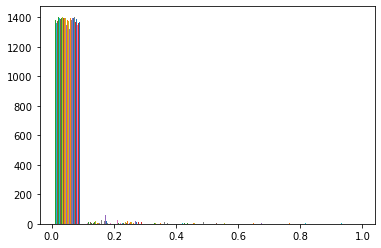

In [63]:
plt.hist(user_cosSim)
plt.show()

In [77]:
print(user_cosSim.shape)
print(1405*1405)
print(np.sum(user_cosSim > 0) - 1405)
print(np.sum(user_cosSim == 0))
print(np.sum(user_cosSim > 0.1) - 1405)

(1405, 1405)
1974025
45350
1927270
32172


In [100]:
activeUsers['LagTimeStamp'] = activeUsers['TimeStamp'].shift()

<ipython-input-100-1f59f14a0c9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activeUsers['LagTimeStamp'] = activeUsers['TimeStamp'].shift()


In [101]:
activeUsers['Gap'] = activeUsers.apply(lambda x: (x['TimeStamp'] - x['LagTimeStamp']).total_seconds(), axis=1)

<ipython-input-101-9ca4341792f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activeUsers['Gap'] = activeUsers.apply(lambda x: (x['TimeStamp'] - x['LagTimeStamp']).total_seconds(), axis=1)


In [102]:
activeUsers

,SessionId,IpId,TimeStamp,Event,Action,Product,LagTimeStamp,Gap
32,18,100180PL,2020-01-13 22:44:22,Arrive,NaN,NaN,NaT,NaN
33,18,100180PL,2020-01-13 22:47:06,Leave,NaN,NaN,2020-01-13 22:44:22,164.0
34,19,100180PL,2020-01-22 19:47:32,Arrive,NaN,NaN,2020-01-13 22:47:06,766826.0
35,19,100180PL,2020-01-22 19:52:22,NaN,add_to_cart,p-6769,2020-01-22 19:47:32,290.0
36,19,100180PL,2020-01-22 19:52:51,NaN,add_to_cart,p-6769,2020-01-22 19:52:22,29.0
...,...,...,...,...,...,...,...,...
112219,40281,99972PL,2020-02-19 20:40:12,NaN,add_to_cart,p-8755,2020-02-19 20:38:26,106.0
112220,40281,99972PL,2020-02-19 20:43:12,NaN,add_to_cart,c-65,2020-02-19 20:40:12,180.0
112221,40281,99972PL,2020-02-19 20:55:41,NaN,add_to_cart,p-8990,2020-02-19 20:43:12,749.0
112222,40281,99972PL,2020-02-19 21:26:17,NaN,order,NaN,2020-02-19 20:55:41,1836.0


In [79]:
def duration(x):
    return (x.max()-x.min()).total_seconds()    

In [105]:
def begin(x):
    return x.min().hour

In [110]:
sessionFeatures = activeUsers.groupby(['IpId','SessionId']).agg(
    Begin = pd.NamedAgg('TimeStamp', begin),
    Duration = pd.NamedAgg('TimeStamp', duration),
    Adds = pd.NamedAgg('Product', 'count'),
    Products = pd.NamedAgg('Product', 'nunique'),
    MeanGap = pd.NamedAgg('Gap', 'mean')
)

In [111]:
sessionFeatures

Begin  Duration  Adds  Products       MeanGap
IpId     SessionId                                               
100180PL 18            22     164.0     0         0  1.640000e+02
         19            19    1207.0     4         3  1.280055e+05
         20            16    4490.0     5         3  1.099243e+04
         21            19    3040.0     6         4  1.075400e+03
         22            19    1727.0     0         0  1.288160e+05
...                   ...       ...   ...       ...           ...
99585PL  40253         19     860.0     0         0 -4.875000e+03
         40254         14    1545.0     4         3  1.014157e+04
         40255         22       0.0     0         0  5.294920e+06
99972PL  40280         20       9.0     0         0 -2.680738e+06
         40281         20    3051.0     4         4  4.569749e+05

[6197 rows x 5 columns]

In [112]:
userFeatures = sessionFeatures.groupby('IpId').agg([np.mean, np.std])

In [113]:
userFeatures

Begin                Duration                    Adds            \
               mean       std          mean          std       mean       std   
IpId                                                                            
100180PL  19.300000  2.773939    797.450000  1189.988920   0.750000  1.860249   
100186PL  21.400000  1.949359    443.400000   779.534990   2.400000  5.366563   
1005PL    10.600000  6.308724    373.400000   834.947783   2.000000  4.472136   
10103PL   14.714286  5.345225    265.285714   457.075747   0.428571  0.534522   
101061PL   8.000000       NaN   4651.000000          NaN  23.000000       NaN   
...             ...       ...           ...          ...        ...       ...   
98804PL   14.000000       NaN  12759.000000          NaN   3.000000       NaN   
9881PL     9.722222  1.934381    101.833333   178.095232   0.166667  0.383482   
99321PL   19.000000  2.000000   1755.333333  1282.497693   5.666667  6.027714   
99585PL   18.333333  4.041452    801.666667   774.150072   1.333333  2.309401   
99972PL   20.000000  0.000000   1530.000000  2151.018828   2.000000  2.828427   

           Products                 MeanGap                
               mean       std          mean           std  
IpId                                                       
100180PL   0.500000  1.235442  3.956187e+04  4.774225e+04  
100186PL   0.600000  1.341641  2.512270e+05  1.040830e+06  
1005PL     1.200000  2.683282  1.263408e+06  1.455665e+06  
10103PL    0.428571  0.534522 -5.824762e+02  2.208019e+06  
101061PL  12.000000       NaN -1.243035e+05           NaN  
...             ...       ...           ...           ...  
98804PL    3.000000       NaN  1.480286e+03           NaN  
9881PL     0.166667  0.383482  2.095709e+05  4.529707e+05  
99321PL    2.666667  2.516611 -2.399559e+05  4.184212e+05  
99585PL    1.000000  1.732051  1.766729e+06  3.055512e+06  
99972PL    2.000000  2.828427 -1.111882e+06  2.218698e+06  

[1405 rows x 10 columns]

In [120]:
userFeatures[userFeatures.index=='1005PL'].values

array([[1.06000000e+01, 6.30872412e+00, 3.73400000e+02, 8.34947783e+02,
        2.00000000e+00, 4.47213595e+00, 1.20000000e+00, 2.68328157e+00,
        1.26340845e+06, 1.45566492e+06]])

In [122]:
np.concatenate((userFeatures[userFeatures.index=='1005PL'].values, userFeatures[userFeatures.index=='99585PL'].values))

array([1.06000000e+01, 6.30872412e+00, 3.73400000e+02, 8.34947783e+02,
       2.00000000e+00, 4.47213595e+00, 1.20000000e+00, 2.68328157e+00,
       1.26340845e+06, 1.45566492e+06])

In [128]:
userLookup = pd.Series(userBaskets.index)

In [154]:
user_pairs = itertools.product(userFeatures.values, repeat=2)

In [133]:
activeIpIds = userBaskets.index

In [182]:
def customRound(x):
    if x > 0.1:
        return 1
    else:
        return 0

In [231]:
vcRound = np.vectorize(customRound)

In [186]:
simRound = vcRound(user_cosSim)

In [189]:
def getSim(x):
    return simRound[userLookup[userLookup==x[0]].index[0], userLookup[userLookup==x[1]].index[0]]

In [191]:
labels = map(getSim, itertools.product(activeIpIds, repeat=2))

In [307]:
class SiameseNetwork(tf.keras.Model):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, input_shape=(10,), activation=tf.nn.leaky_relu),
            tf.keras.layers.Dense(10, input_shape=(10,), activation=tf.nn.leaky_relu),
            tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu)
        ])
        
    @staticmethod
    def pairwise_cosine_sim(y1, y2):
        
        y1_norm = tf.nn.l2_normalize(y1, 1)
        y2_norm = tf.nn.l2_normalize(y2, 1)
        return tf.matmul(y1_norm, y2_norm, transpose_b=True)
    
    @tf.function
    def call(self, x1, x2):
        
        y1 = self.model(x1)
        y2 = self.model(x2)
        return tf.reshape(tf.linalg.diag_part(self.pairwise_cosine_sim(y1, y2)), [1,-1])

In [308]:
model = SiameseNetwork()

In [302]:
user_pairs_small = np.array(list(itertools.product(userFeatures.head().values, repeat=2)))

In [303]:
model(user_pairs_small[:,0],user_pairs_small[:,1])

<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
array([[0.9999999 , 0.9970128 , 0.99999994, 0.9948714 ,        nan,
        0.9970128 , 1.0000002 , 0.99700654, 0.99971193,        nan,
        0.99999994, 0.99700654, 0.99999994, 0.99486315,        nan,
        0.9948714 , 0.99971193, 0.99486315, 0.99999994,        nan,
               nan,        nan,        nan,        nan,        nan]],
      dtype=float32)>

In [279]:
activeIpIds_small = userBaskets.head().index
labels_small = list(map(getSim, itertools.product(activeIpIds_small, repeat=2)))

In [297]:
print(user_pairs_small.shape)
print(len(labels_small))

(25, 2, 10)
25


In [201]:
def contrastive_loss(cos_similarity, label, margin=1.0):
    """Contrastive loss function
    """
    distance = 1.0 - cos_similarity
    similarity = label * distance                                           
    dissimilarity = (1 - label) * tf.square(tf.maximum((margin - distance), 0))
    return 0.5 * tf.reduce_mean(dissimilarity + similarity)

In [289]:
user_pairs_small[:,0][0].reshape(1,-1)

array([[1.93000000e+01, 2.77393887e+00, 7.97450000e+02, 1.18998892e+03,
        7.50000000e-01, 1.86024899e+00, 5.00000000e-01, 1.23544154e+00,
        3.95618664e+04, 4.77422453e+04]])

In [304]:
model(user_pairs_small[:,0][1].reshape(1,-1), 
                                      user_pairs_small[:,1][1].reshape(1,-1))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99701273]], dtype=float32)>

In [305]:
contrastive_loss(model(user_pairs_small[:,0][0].reshape(1,-1), 
                                      user_pairs_small[:,1][0].reshape(1,-1)), 
                                labels_small[0], margin=1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [310]:
for j in range(len(labels_small)):
               print(contrastive_loss(model(user_pairs_small[:,0][j].reshape(1,-1), 
                                      user_pairs_small[:,1][j].reshape(1,-1)), 
                                labels_small[j], margin=1.0))

tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)


In [309]:
epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
for epoch in range(epochs):
    accuracy = tf.keras.metrics.BinaryAccuracy()
    epoch_loss = tf.keras.metrics.Mean()
    for j in range(len(labels_small)):
        with tf.GradientTape() as tape:
            user_similarity = model(user_pairs_small[:,0][j].reshape(1,-1), user_pairs_small[:,0][j].reshape(1,-1))
            loss = contrastive_loss(user_similarity, labels_small[j], margin=1.0)
            grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        epoch_loss.update_state(loss)
        accuracy.update_state(tf.reshape(label, (1,-1)), user_similarity)
        
    print(
        "Epoch {:03d}: Loss: {:.3f} Accuraccy: {:.3f}".format(
            epoch,
            epoch_loss.result(),
            accuracy.result()
        )    
    )

Epoch 000: Loss: nan Accuraccy: 0.200
Epoch 001: Loss: nan Accuraccy: 1.000
Epoch 002: Loss: nan Accuraccy: 1.000
Epoch 003: Loss: nan Accuraccy: 1.000
Epoch 004: Loss: nan Accuraccy: 1.000
Epoch 005: Loss: nan Accuraccy: 1.000
Epoch 006: Loss: nan Accuraccy: 1.000
Epoch 007: Loss: nan Accuraccy: 1.000
Epoch 008: Loss: nan Accuraccy: 1.000
Epoch 009: Loss: nan Accuraccy: 1.000


First we create a session_item table. It is our assumption that the most useful recommendations stem from looking at products purchased together in the same session, rather than simply by the same user. We will do user_item later.

In [6]:
withProduct = train[~train['Product'].isnull()]
session_item = pd.DataFrame(withProduct.groupby('SessionId')['Product'].apply(set))
print(session_item.shape)

(8401, 1)


In [7]:
def non_overlap_pair(kind, s1, s2, included=None):
    if not included:
        return (
            (kind, key[0], key[1], 1) 
            for key in itertools.product(s1, s2)  
            if key[0]!=key[1]
        )
    else:
        return (
            (kind, key[0], key[1], 1) 
            for key in itertools.product(s1, s2)  
            if (key[0]!=key[1]) and (key in included)
        )

In [8]:
start = time.time()
lst = session_item["Product"].to_list()
num_sessions = session_item.shape[0]
all_item = set(items)

both = itertools.chain(
    *(
        non_overlap_pair(0, u_item, u_item) 
        for u_item in lst
    ))


included = set(itertools.chain(
    *(
        (key for key in itertools.product(u_item, u_item) if key[0]!=key[1])
        for u_item in lst 
    )))


first = itertools.chain(
    *(
        non_overlap_pair(1, u_item, all_item-u_item, included) 
        for u_item in lst
    ))


second = itertools.chain(
    *(
        non_overlap_pair(2, all_item-u_item, u_item, included) 
        for u_item in lst
    ))

itemCooc = pd.DataFrame(
    itertools.chain(first, second, both), columns=["kind", "item1", "item2", "freq"])
itemCooc = itemCooc.groupby(["kind", "item1", "item2"]).sum()
itemCooc = itemCooc.unstack(0)
print( time.time() - start)
itemCooc.head()

33.04260587692261


freq            
kind               0     1     2
item1 item2                     
c-21  c-24_205   1.0  53.0  10.0
      c-24_209   1.0  53.0  14.0
      c-24_211   1.0  53.0   1.0
      c-261      2.0  52.0  21.0
      c-272_312  2.0  52.0  54.0

In [9]:
itemCooc[('freq', 3)] = num_sessions - itemCooc[('freq', 0)] - itemCooc[('freq', 1)] - itemCooc[('freq', 2)]
itemCooc.head()

freq                    
kind               0     1     2       3
item1 item2                             
c-21  c-24_205   1.0  53.0  10.0  8337.0
      c-24_209   1.0  53.0  14.0  8333.0
      c-24_211   1.0  53.0   1.0  8346.0
      c-261      2.0  52.0  21.0  8326.0
      c-272_312  2.0  52.0  54.0  8293.0

In [10]:
# itemCooc[('freq',0)].value_counts()

In [11]:
def shannon(v):
    S = np.sum(v)
    return np.dot(v/S,np.log(np.add(v/S,v==0)))

In [12]:
def llr(x):
    v = np.array([x[('freq', 0)], x[('freq', 1)], x[('freq', 2)], x[('freq', 3)]])
    return 2*np.sum(v)*(shannon(v) - \
                        shannon([v[0]+v[1], v[2]+v[3]]) - \
                        shannon([v[0]+v[2], v[1]+v[3]])
                       )

In [13]:
itemCooc_llr = itemCooc.apply(lambda x: llr(x), axis=1)
itemCooc_llr.head()

item1  item2    
c-21   c-24_205     3.537431
       c-24_209     2.942233
       c-24_211     7.352830
       c-261        6.933982
       c-272_312    3.679396
dtype: float64

In [43]:
llrDf = pd.DataFrame(itemCooc_llr).rename(columns={0:'Llr'}).dropna().reset_index()

In [51]:
llrDf[llrDf['item1']=='c-21'].sort_values('Llr', ascending=False).head(2)['item2']

21      c-61
51    p-3631
Name: item2, dtype: object